# Regression Analysis: Predicting Melbourne Housing Market Prices

<br>

Housing prices have steadily increased over the course of the past three decades with the exception of severe economic downturns such as the economic recession of 2008. 
The housing market is not only a very strong economic indicator but it has a financial impact on anyone looking to own a home themselves. 
To better understand the effects that individual factors have on the housing prices, I am interested in using supervised learning techniques to model housing prices.
By using machine learning techniques to do this the process can be automated to include a large amount of data points and different trends can be detected that may not be readily apparent to humans.


In this study, several types of supervised learning classification models were used to predict housing prices in Melbourne, Australia. Models focused on utilizing multiple housing price indicators, including factors related to the size and location of the living spaces. The different models were compared to better understand their ability to utilize the data to accurately predict the housing market using multiple forms of statistical evaluation. The process used to undertake this study is as follows:

<br>


Data Exploration and Analysis
* Viewing the Distribution of the Datapoints
* Checking the Range of the Classes
* Interpreting Descriptive Statistics

Preparing The Data For Modeling
* Imputing Outliers
* Normalization Linear Transformations
* Feature Selection

Modeling the Data 
1. Using All Available Features
2. Using PCA Components
3. Using Selectkbest Function


In [1]:
%%time

import math
import re
import warnings

from IPython.display import display
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
from matplotlib.mlab import PCA as mlabPCA
from sklearn.naive_bayes import BernoulliNB
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn import neighbors
from sklearn.utils import resample
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn import ensemble
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, SVR, NuSVR
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import KernelPCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.metrics import mean_squared_error

from datetime import datetime
from dateutil.parser import parse
from nltk.stem.porter import PorterStemmer


# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="sklearn"  
    )


# Set Plot Style
sns.set_style('darkgrid')

# Set Float Format
#pd.options.display.float_format = '{:,.0f}'.format

CPU times: user 1.6 s, sys: 461 ms, total: 2.06 s
Wall time: 1.6 s


In [2]:
%%time

## Define Functions

# Converting to datetime
def alt_to_datetime(x):
    return  pd.to_datetime(x, format='%d/%m/%Y', errors='coerce')

# Definine RMSE function for Model Evaluation
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())


CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 10.3 µs


In [3]:
%%time

## Import Files

df1 = pd.read_csv('MELBOURNE_HOUSE_PRICES_LESS.csv')
df2 = pd.read_csv('Melbourne_housing_FULL.csv')


CPU times: user 235 ms, sys: 50.4 ms, total: 285 ms
Wall time: 287 ms


In [4]:
## View Data for Cleaning

#df1.head(7)
#df1.dtypes
#df1.describe()
#df1.isnull().sum(axis = 0)
#len(df1)

#df2.head(7)
#df2.dtypes
#df2.describe()
#df2.isnull().sum(axis = 0)
#len(df2)


In [5]:
%%time

## Reorder Columns in df2 

df2 = df2[['Suburb',
        'Address',
        'Rooms',
        'Type',
        'Price',
        'Method',
        'SellerG',
        'Date',
        'Postcode',
        'Regionname',
        'Propertycount',
        'Distance',
        'CouncilArea',
        'Bedroom2',
        'Bathroom',
        'BuildingArea']]

## Make Postcodes in df2 Match Format of Postcodes in df1

#df2.query('Postcode.isnull()')
df2.loc[df2['Suburb'] == 'Fawkner Lot', 'Postcode'] = 3060
#df2.loc[df2['Suburb'] == 'Fawkner Lot']
df2.Postcode = df2.Postcode.apply(int)

## Impute Null Price Values  in both DataFrames With Mean Price of Houses of the Relevant Number of Rooms

for x in list(df1.Rooms.unique()):
    df1.loc[df1['Rooms'] == x, 'Price'] = df1.loc[df1['Rooms'] == x].Price.fillna(df1.loc[df1['Rooms'] == x].Price.mean())
    
for x in list(df2.Rooms.unique()):
    df2.loc[df2['Rooms'] == x, 'Price'] = df2.loc[df2['Rooms'] == x].Price.fillna(df2.loc[df2['Rooms'] == x].Price.mean())  
    

CPU times: user 215 ms, sys: 13.8 ms, total: 229 ms
Wall time: 228 ms


In [6]:
### Imputing Null Values in df2

## Drop Unnecessary Values

df2 = df2.drop(df2.index[29483])
df2 = df2.drop('Bedroom2', axis=1)

## Imputing Regionname Values

df2.iloc[18523, 9] = list(df2.loc[df2['Suburb'] == 'Footscray', 'Regionname'].mode())
df2.iloc[26888, 9] = list(df2.loc[df2['Suburb'] == 'Camberwell', 'Regionname'].mode())


## Imputing Regionname Values

df2.iloc[18523, 10] = list(df2.loc[df2['Suburb'] == 'Footscray', 'Propertycount'].mode())
df2.iloc[26888, 10] = list(df2.loc[df2['Suburb'] == 'Camberwell', 'Propertycount'].mode())

## Imputing CouncilArea Values

df2.iloc[18523, 12] = list(df2.loc[df2['Suburb'] == 'Footscray', 'CouncilArea'].mode())
df2.iloc[26888, 12] = list(df2.loc[df2['Suburb'] == 'Camberwell', 'CouncilArea'].mode())


In [7]:
%%time

## Merge the two DataFrames

df = pd.concat([df1, df2])

## Reset Index

df.reset_index(inplace=True)
df.drop("index",axis=1,inplace=True)


CPU times: user 50.6 ms, sys: 13.8 ms, total: 64.4 ms
Wall time: 63.6 ms


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


In [8]:
### Impute Null Values in Combined DataFrame

## Drop Unnecessary Values

df = df.drop(df[df.Rooms > 8].index)
df = df.drop(df.index[7452])

## Impute Null Bathroom Count Values

for x in list(df.Rooms.unique()):
    df.loc[df['Rooms'] == x, 'Bathroom'] = df.loc[df['Rooms'] == x].Bathroom.fillna(df.loc[df['Rooms'] == x].Bathroom.mean())

## Impute Null BuildingArea Values

for x in list(df.Rooms.unique()):
    df.loc[df['Rooms'] == x, 'BuildingArea'] = df.loc[df['Rooms'] == x].BuildingArea.fillna(df.loc[df['Rooms'] == x].BuildingArea.mean())
    


In [9]:
## Convert Date to Datetime

df['Date'] = df.Date.apply(alt_to_datetime)

## Convert Datetime to Float

df['Date'] = df.Date.apply(lambda x: datetime.toordinal(x))

## Make Postcodes Categorical

df.Postcode = df.Postcode.apply(str)

## Shorten Council Area Names For Readability

df.CouncilArea = df.CouncilArea.apply(lambda x: str(x).replace(' City Council',''))


## Data Exploration and Analysis

Dataset used for this study includes information about home purchases in Melbourne pertaining to the homes and the circumstances in which they were sold. Such information includes: the location of the homes, the number of rooms in the homes, the type of home, the method in which the home was sold, and the seller of the home.

In [10]:
%%time

df.head(7)

CPU times: user 863 µs, sys: 126 µs, total: 989 µs
Wall time: 895 µs


,Address,Bathroom,BuildingArea,CouncilArea,Date,Distance,Method,Postcode,Price,Propertycount,Regionname,Rooms,SellerG,Suburb,Type
0,49 Lithgow St,1.493,140.406,Yarra,736420,3.000,S,3067,1490000.000,4019.000,Northern Metropolitan,3,Jellis,Abbotsford,h
1,59A Turner St,1.493,140.406,Yarra,736420,3.000,S,3067,1220000.000,4019.000,Northern Metropolitan,3,Marshall,Abbotsford,h
2,119B Yarra St,1.493,140.406,Yarra,736420,3.000,S,3067,1420000.000,4019.000,Northern Metropolitan,3,Nelson,Abbotsford,h
3,68 Vida St,1.493,140.406,Moonee Valley,736420,7.500,S,3040,1515000.000,1543.000,Western Metropolitan,3,Barry,Aberfeldie,h
4,92 Clydesdale Rd,1.141,93.104,Moonee Valley,736420,10.400,S,3042,670000.000,3464.000,Western Metropolitan,2,Nelson,Airport West,h
5,4/32 Earl St,1.141,93.104,Moonee Valley,736420,10.400,S,3042,530000.000,3464.000,Western Metropolitan,2,Jellis,Airport West,t
6,3/74 Hawker St,1.141,93.104,Moonee Valley,736420,10.400,S,3042,540000.000,3464.000,Western Metropolitan,2,Barry,Airport West,u


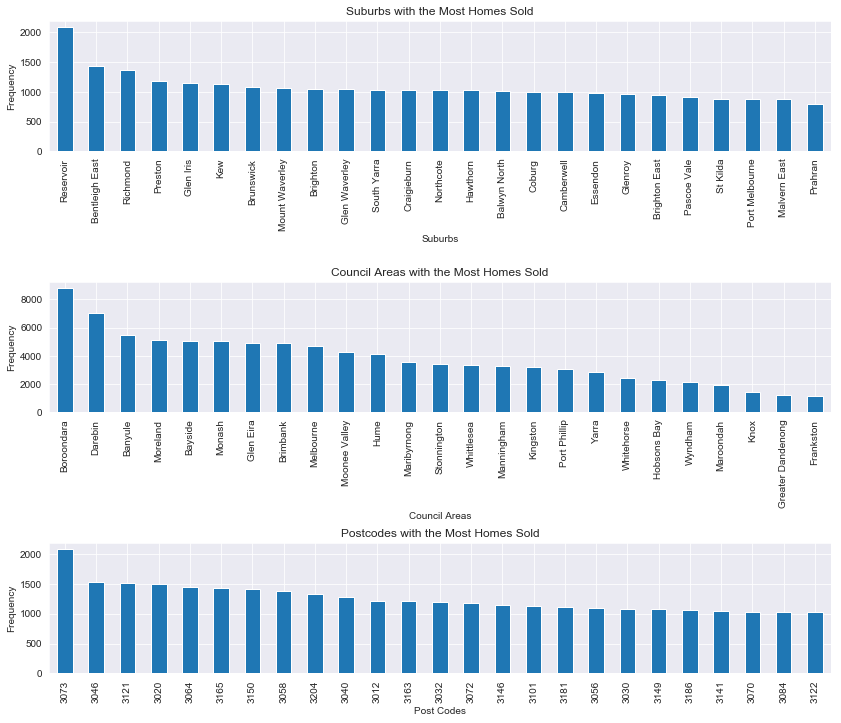

CPU times: user 2.04 s, sys: 297 ms, total: 2.34 s
Wall time: 1.25 s


In [11]:
%%time

## Barplot of Specific Suburbs

fig = plt.figure(figsize=(14, 12))
fig.subplots_adjust(hspace=1)

plt.subplot(3, 1, 1)
ax = df.Suburb.value_counts().head(25).plot(kind='bar',
                                    
                                    title="Suburbs with the Most Homes Sold")
ax.set_xlabel("Suburbs")
ax.set_ylabel("Frequency")

## Barplot of Specific Council Areas

plt.subplot(3, 1, 2)
ax = df.CouncilArea.value_counts().head(25).plot(kind='bar',
                                    
                                    title="Council Areas with the Most Homes Sold")
ax.set_xlabel("Council Areas")
ax.set_ylabel("Frequency")

## Barplot of Specific Postcodes

plt.subplot(3, 1, 3)
ax = df.Postcode.value_counts().head(25).plot(kind='bar',
                                    
                                    title="Postcodes with the Most Homes Sold")
ax.set_xlabel("Post Codes")
ax.set_ylabel("Frequency")

plt.show()

With the exception of the top selling areas, there is a similar amount of homes sold among the Post Codes and Suburbs with the most homes sold. There apprars to be a sharper disparity in the council areas with the homes sold which is more reflective of greater difference in size of these areas. Each of these variables result in a large number of classes with fewer datapoints in each, which may not be as useful for modeling.

CPU times: user 69.7 ms, sys: 3.43 ms, total: 73.1 ms
Wall time: 71.4 ms


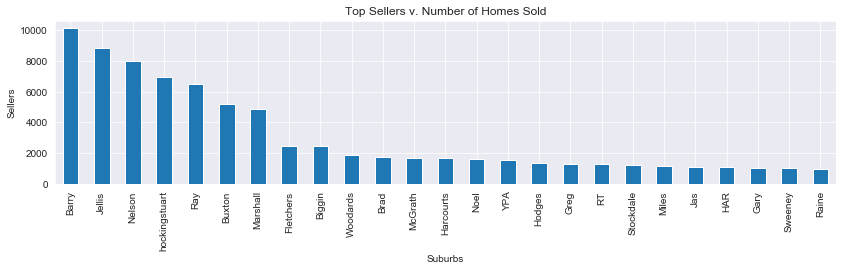

In [12]:
%%time

## Barplot of Specific Suburbs

fig = plt.figure(figsize=(14, 12))
fig.subplots_adjust(hspace=.5)

plt.subplot(3, 1, 1)
ax = df.SellerG.value_counts().head(25).plot(kind='bar',
                                    
                                    title="Top Sellers v. Number of Homes Sold")
ax.set_xlabel("Suburbs")
ax.set_ylabel("Sellers")



Aside from a few top selling real estate agents, there's a large number of agents (over 400) that sold less than two thousand homes.

In [13]:
df.Method.value_counts()

S     53789
PI    14635
SP    14005
VB     9060
SN     3989
PN      959
W       657
SA      642
SS      109
Name: Method, dtype: int64

The vast majority of the transactions involved the homes being sold outright. Property being passed on or sold via auction make a minority of the transactions.

In [14]:
df.Type.value_counts()

h    69000
u    18952
t     9893
Name: Type, dtype: int64

Most of the homes included in this data were houses, which outnember units and townhouses combined.

In [15]:
df.Regionname.value_counts()

Southern Metropolitan         29385
Northern Metropolitan         26329
Western Metropolitan          18517
Eastern Metropolitan          14766
South-Eastern Metropolitan     6946
Eastern Victoria                792
Northern Victoria               759
Western Victoria                351
Name: Regionname, dtype: int64

By using the region name, the data falls into fewer, larger classes than with post codes, council areas or suburbs.

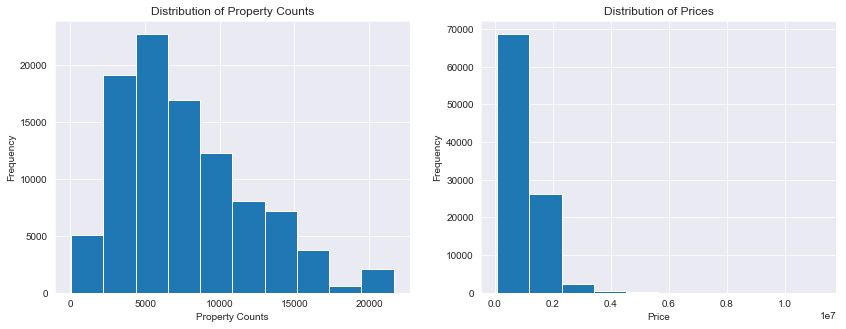

In [16]:
## Plotting Histograms of Property Counts and Prices
plt.figure(figsize=(14, 5))

plt.subplot(1,2,1)
plt.hist(df.Propertycount)
plt.title("Distribution of Property Counts")
plt.xlabel("Property Counts")
plt.ylabel("Frequency")

plt.subplot(1,2,2)
plt.hist(df.Price)
plt.title("Distribution of Prices")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

The frequency of property counts show has a distribution where there are thousands of observations for most ranges and there is little prescence of outliers. These qualities make property count likely to be a useful feature when interpreting the data.

The price variable, the outcome that I predicted on the other hand, showed signs of existing outliers. These outliers would be further explored and corrected prior to modeling.

In [17]:
%%time

df.describe()

CPU times: user 105 ms, sys: 24 ms, total: 129 ms
Wall time: 75.3 ms


,Bathroom,BuildingArea,Date,Distance,Price,Propertycount,Rooms
count,97845.000,97845.000,97845.000,97845.000,97845.000,97845.000,97845.000
mean,1.615,155.333,736519.522,12.151,1027307.202,7602.077,3.080
std,0.536,161.045,242.807,7.351,554515.464,4426.052,0.949
min,0.000,0.000,735991.000,0.000,85000.000,39.000,1.000
25%,1.141,93.104,736295.000,6.700,675000.000,4380.000,2.000
50%,1.493,140.406,736553.000,11.000,940000.000,6786.000,3.000
75%,2.000,210.576,736700.000,16.000,1236714.827,10412.000,4.000
max,12.000,44515.000,736980.000,64.100,11200000.000,21650.000,8.000


Extreme values could be found in the building area and property count variables. Data denoting the number of rooms and bathrooms on the other hand has much smaller ranges.

## Preparing The Data For Modeling

In [18]:
%%time

## Establish Columns to Be Used based on Categorical Value Counts

df = df[['Rooms', 'Distance', 'Propertycount', 'Type', 'Method', 'Regionname', 'CouncilArea', 'Price']]

CPU times: user 10.2 ms, sys: 2.87 ms, total: 13 ms
Wall time: 11.3 ms


Categorical variables that didn't have a very large number of classes were kept for the model to prevent its performance from being hampered.

In [19]:
%%time

## Replace extreme values 

up_quantiles = df.quantile(0.95)
outliers_high = (df > df.quantile(0.95))
df[outliers_high] = np.nan
df.fillna(up_quantiles, inplace=True)

CPU times: user 106 ms, sys: 10.8 ms, total: 117 ms
Wall time: 122 ms


In [20]:
## Normalization and Linear Transformations

df.Rooms = (df.Rooms - df.Rooms.min())/(df.Rooms.max() - df.Rooms.min())
df.Distance = (df.Distance - df.Distance.min())/(df.Distance.max() - df.Distance.min())
df.Propertycount = (df.Propertycount - df.Propertycount.min())/(df.Propertycount.max() - df.Propertycount.min())

df.Price = df.Price.apply(math.log)

In [21]:
%%time

## Get Dummies so Categorical Variables Can be Used in Regression

df = pd.get_dummies(df)

## Display New Number of Features

print('Number of Features: '+ str(len(df.columns)))


Number of Features: 58
CPU times: user 52.2 ms, sys: 9.17 ms, total: 61.3 ms
Wall time: 59.3 ms


In [22]:
%%time

## Establish variables based on original features to be used for modeling

x = df.drop(['Price'], axis=1)
y = df.Price


CPU times: user 10.6 ms, sys: 4.32 ms, total: 14.9 ms
Wall time: 13 ms


In [23]:
%%time

## PCA

# Normalize the data for PCA

X = StandardScaler().fit_transform(x)

# Perform PCA

sklearn_pca = PCA(n_components=20)
Y_sklearn = sklearn_pca.fit_transform(X)

# Turn PCA Result into Dataframe

pca_components = pd.DataFrame(data=Y_sklearn)

print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_
)


The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [0.05736541 0.04283042 0.04098472 0.03671223 0.03423057 0.03286944
 0.0317343  0.02830331 0.02809266 0.02464089 0.02322692 0.02104111
 0.02003836 0.01940198 0.01888658 0.01858406 0.01850232 0.01828263
 0.01822392 0.0181573 ]
CPU times: user 3.18 s, sys: 1.12 s, total: 4.3 s
Wall time: 933 ms


In [24]:
%%time

## Establish variables based on select K best to be used for modeling

selector = SelectKBest(f_classif, k=25)
k_predictors = selector.fit_transform(x,y)

CPU times: user 1.09 s, sys: 91.3 ms, total: 1.19 s
Wall time: 1.2 s


In [25]:
%%time

## Train Test Split Original Variables And K Selected Variables for Modeling

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=20)

kx_train, kx_test, ky_train, ky_test = train_test_split(k_predictors, y, test_size=0.2, random_state=21)

px_train, px_test, py_train, py_test = train_test_split(pca_components, y, test_size=0.2, random_state=21)


CPU times: user 83.3 ms, sys: 25.1 ms, total: 108 ms
Wall time: 107 ms


## Modeling the Data using all available Features

### Linear Regression

In [26]:
%%time

## train and fit model

regr = linear_model.LinearRegression().fit(x_train, y_train)

CPU times: user 365 ms, sys: 37.7 ms, total: 402 ms
Wall time: 154 ms


In [27]:
%%time

## Model Evaluation

print("accuracy score:\n" + str(regr.score(x_test, y_test))+'\n')

print("cross validation:\n" + str(cross_val_score(regr, x_test, y_test, cv=5))+'\n')

print('RMSE: ' + str(rmse(regr.predict(x_test), y_test)))

accuracy score:
0.6554818379673324

cross validation:
[0.65020109 0.64819587 0.6672538  0.66042741 0.64593618]

RMSE: 0.25591297063312535
CPU times: user 933 ms, sys: 222 ms, total: 1.15 s
Wall time: 184 ms


### K Nearest Neighbors 

In [28]:
%%time

## train and fit model

knn = neighbors.KNeighborsRegressor(n_neighbors=10).fit(x_train, y_train)

CPU times: user 5.49 s, sys: 55.9 ms, total: 5.55 s
Wall time: 5.6 s


In [29]:
%%time

## Model Evaluation

print("accuracy score:\n" + str(knn.score(x_test, y_test))+'\n')

print("cross validation:\n" + str(cross_val_score(knn, x_test, y_test, cv=5))+'\n')

print('RMSE: ' + str(rmse(knn.predict(x_test), y_test)))


accuracy score:
0.7377193118403025

cross validation:
[0.68162125 0.66202621 0.69920477 0.69558934 0.6870499 ]

RMSE: 0.22329006212615407
CPU times: user 47.8 s, sys: 278 ms, total: 48.1 s
Wall time: 48.5 s


### Decision Tree

In [30]:
%%time

## train and fit model

decision_tree = tree.DecisionTreeRegressor(
    max_features=10,
    max_depth=100,
    ).fit(x_train, y_train)


CPU times: user 140 ms, sys: 27.7 ms, total: 168 ms
Wall time: 166 ms


In [31]:
%%time

## Model Evaluation

print("accuracy score:\n" + str(decision_tree.score(x_test, y_test))+'\n')

print("cross validation:\n" + str(cross_val_score(decision_tree, x_test, y_test, cv=5))+'\n')

print('RMSE: ' + str(rmse(decision_tree.predict(x_test), y_test)))


accuracy score:
0.7479054604916736

cross validation:
[0.63769201 0.64628347 0.67084755 0.63400314 0.66111049]

RMSE: 0.21891118741869403
CPU times: user 209 ms, sys: 35 ms, total: 244 ms
Wall time: 244 ms


### Random Forest

In [32]:
%%time

## Fit and Train Model

rfr = ensemble.RandomForestRegressor(
    max_features=10,
    max_depth=100,
    ).fit(x_train, y_train)


CPU times: user 829 ms, sys: 38.3 ms, total: 867 ms
Wall time: 881 ms


In [33]:
%%time

## Model Evaluation

print("accuracy score:\n" + str(rfr.score(x_test, y_test))+'\n')

print("cross validation:\n" + str(cross_val_score(rfr, x_test, y_test, cv=5))+'\n')

print('RMSE: ' + str(rmse(rfr.predict(x_test), y_test)))


accuracy score:
0.7587281677852276

cross validation:
[0.7001267  0.70259043 0.72497107 0.71053659 0.71227038]

RMSE: 0.21416058694023726
CPU times: user 1.08 s, sys: 65.2 ms, total: 1.14 s
Wall time: 1.15 s


### Gradient Boost 

In [34]:
%%time

## train and fit model

re = ensemble.GradientBoostingRegressor()

parameters = { 
              'n_estimators': list(np.arange(200, 401, 50)),
              'max_depth': list(range(1,5)),
             }

r2_scorer = make_scorer(r2_score)

reg = GridSearchCV(re, parameters, scoring=r2_scorer).fit(x_train,  y_train)

## Show Best Parameters
print(reg.best_params_)


{'max_depth': 4, 'n_estimators': 400}
CPU times: user 14min 42s, sys: 8.49 s, total: 14min 50s
Wall time: 15min 3s


In [36]:
%%time

## Model Evaluation

print("accuracy score:\n" + str(reg.score(x_test, y_test))+'\n')

print("cross validation:\n" + str(cross_val_score(reg, x_test, y_test, cv=5))+'\n')

print('RMSE: ' + str(rmse(reg.predict(x_test), y_test)))


accuracy score:
0.7589473319543428

cross validation:
[0.74373468 0.73823348 0.76311434 0.76003719 0.74564779]

RMSE: 0.214063296281816
CPU times: user 13min 46s, sys: 6.24 s, total: 13min 52s
Wall time: 18min 56s


The gradient boost model had the best performance out of all of the models run with all of the dataset's useful features. Cross vadidation showed few signs of overfitting with this model. The strength of this model when it comes to making predictions using this data comes from its ability to reduce error over multiple iterations, resulting in higher accuracy scores after a high number of iterations. Using all of the available features in the dataset could leave a model vulnerable to weak features (which could hurt accuracy), but the model overcomes that through its ability to directly focus reducing error. The random forest and knn models also had similar accuracy scores to the gradient boost model, but their cross validation scores were lower.


## Modeling the Data using PCA Components

### Linear Regression

In [37]:
%%time

## train and fit model

p_regr = linear_model.LinearRegression().fit(px_train, py_train)


CPU times: user 79.3 ms, sys: 79.1 ms, total: 158 ms
Wall time: 170 ms


In [38]:
%%time

## Model Evaluation

print("accuracy score:\n" + str(p_regr.score(px_test, py_test))+'\n')

print("cross validation:\n" + str(cross_val_score(p_regr, px_test, py_test, cv=5))+'\n')

print('RMSE: ' + str(rmse(p_regr.predict(px_test), py_test)))


accuracy score:
0.5030878678329703

cross validation:
[0.50806286 0.49279613 0.49611531 0.51229806 0.50048328]

RMSE: 0.30806022598109145
CPU times: user 402 ms, sys: 137 ms, total: 540 ms
Wall time: 89.9 ms


### K Nearest Neighbors 

In [39]:
%%time

## train and fit model

p_knn = neighbors.KNeighborsRegressor(n_neighbors=10).fit(px_train, py_train)

CPU times: user 120 ms, sys: 24.6 ms, total: 145 ms
Wall time: 157 ms


In [40]:
%%time

## Model Evaluation

print("accuracy score:\n" + str(p_knn.score(px_test, py_test))+'\n')

print("cross validation:\n" + str(cross_val_score(p_knn, px_test, py_test, cv=5))+'\n')

print('RMSE: ' + str(rmse(p_knn.predict(px_test), py_test)))


accuracy score:
0.7325633961116327

cross validation:
[0.6825508  0.66356092 0.6704457  0.67694743 0.66932064]

RMSE: 0.22599886281472986
CPU times: user 2 s, sys: 36.9 ms, total: 2.04 s
Wall time: 2.07 s


### Decision Tree

In [41]:
%%time

## train and fit model

p_decision_tree = tree.DecisionTreeRegressor(
    max_features=10,
    max_depth=100,
    ).fit(px_train, py_train)


CPU times: user 489 ms, sys: 6.56 ms, total: 496 ms
Wall time: 499 ms


In [42]:
%%time

## Model Evaluation

print("accuracy score:\n" + str(p_decision_tree.score(px_test, py_test))+'\n')

print("cross validation:\n" + str(cross_val_score(decision_tree, px_test, py_test, cv=5))+'\n')

print('RMSE: ' + str(rmse(p_decision_tree.predict(px_test), py_test)))


accuracy score:
0.7481527829844821

cross validation:
[0.66116194 0.62890079 0.6206433  0.61572942 0.63935557]

RMSE: 0.21931301612750023
CPU times: user 654 ms, sys: 6.78 ms, total: 661 ms
Wall time: 664 ms


### Random Forest

In [43]:
%%time

## Fit and Train Model

p_rfr = ensemble.RandomForestRegressor(
    max_features=10,
    max_depth=100,
    ).fit(px_train, py_train)


CPU times: user 3.43 s, sys: 40.6 ms, total: 3.47 s
Wall time: 3.52 s


In [44]:
%%time

## Model Evaluation

print("accuracy score:\n" + str(p_rfr.score(px_test, py_test))+'\n')

print("cross validation:\n" + str(cross_val_score(p_rfr, px_test, py_test, cv=5))+'\n')

print('RMSE: ' + str(rmse(p_rfr.predict(px_test), py_test)))


accuracy score:
0.7557480495570719

cross validation:
[0.71295825 0.69382045 0.68699159 0.69955297 0.69345797]

RMSE: 0.21598065293150928
CPU times: user 4.4 s, sys: 54.1 ms, total: 4.46 s
Wall time: 4.52 s


### Gradient Boost 

In [45]:
%%time

## train and fit model

p_re = ensemble.GradientBoostingRegressor()

parameters = { 
              'n_estimators': list(np.arange(200, 401, 50)),
              'max_depth': list(range(1,5))
             }

acc_scorer = make_scorer(r2_score)

p_reg = GridSearchCV(p_re, parameters, scoring=acc_scorer).fit(px_train, py_train)

## Show Best Parameters
print(p_reg.best_params_)


{'max_depth': 4, 'n_estimators': 400}
CPU times: user 18min 21s, sys: 6.32 s, total: 18min 28s
Wall time: 18min 40s


In [46]:
%%time

## Model Evaluation

print("accuracy score:\n" + str(p_reg.score(px_test, py_test))+'\n')

print("cross validation:\n" + str(cross_val_score(p_reg, px_test, py_test, cv=5))+'\n')

print('RMSE: ' + str(rmse(p_reg.predict(px_test), py_test)))


accuracy score:
0.7407961774045213

cross validation:
[0.72648411 0.70852419 0.71188499 0.72554533 0.71467114]

RMSE: 0.22249309151772126
CPU times: user 18min 45s, sys: 8.5 s, total: 18min 53s
Wall time: 19min 10s



The gradient boost model had the best performance out of all of the models run with 20 of the dataset's PCA components. While cross vadidation did showed few signs of overfitting with this model, the scores were significantly lower than the accuracy score. This is a noticable difference from the gradient boost model that used all of the available features. Using a limited number of PCA components from the dataset likely removed some variance that was important to the predictive accuracy of the models. This can be seen in the sharp drop of performance in the naive bayes model. The random forest and knn models also had similar accuracy scores to the gradient boost model, but their cross validation scores were low as well.



## Modeling the Data using Features Chosen through the SelectKbest Function

### Linear Regression

In [47]:
%%time

## train and fit model

k_regr = linear_model.LinearRegression().fit(kx_train, ky_train)

CPU times: user 106 ms, sys: 70.3 ms, total: 176 ms
Wall time: 138 ms


In [48]:
%%time

## Model Evaluation

print("accuracy score:\n" + str(k_regr.score(kx_test, ky_test))+'\n')

print("cross validation:\n" + str(cross_val_score(k_regr, kx_test, ky_test, cv=5))+'\n')

print('RMSE: ' + str(rmse(k_regr.predict(kx_test), ky_test)))


accuracy score:
0.6423702734460872

cross validation:
[0.65007419 0.63049271 0.62826453 0.65465068 0.64323639]

RMSE: 0.261344060753883
CPU times: user 393 ms, sys: 192 ms, total: 585 ms
Wall time: 125 ms


### K Nearest Neighbors 

In [49]:
%%time

## train and fit model

k_knn = neighbors.KNeighborsRegressor(n_neighbors=10).fit(kx_train, ky_train)


CPU times: user 3.95 s, sys: 49.2 ms, total: 3.99 s
Wall time: 4.12 s


In [50]:
%%time

## Model Evaluation

print("accuracy score:\n" + str(k_knn.score(kx_test, ky_test))+'\n')

print("cross validation:\n" + str(cross_val_score(k_knn, kx_test, ky_test, cv=5))+'\n')

print('RMSE: ' + str(rmse(k_knn.predict(kx_test), ky_test)))


accuracy score:
0.7304730679361253

cross validation:
[0.70513445 0.68780232 0.69425137 0.70833818 0.69695175]

RMSE: 0.22688036568655084
CPU times: user 18.2 s, sys: 151 ms, total: 18.3 s
Wall time: 18.6 s


### Decision Tree

In [51]:
%%time

## train and fit model

k_decision_tree = tree.DecisionTreeRegressor(
    max_features=10,
    max_depth=100,
    ).fit(kx_train, ky_train)


CPU times: user 102 ms, sys: 7.92 ms, total: 110 ms
Wall time: 111 ms


In [52]:
%%time

## Model Evaluation

print("accuracy score:\n" + str(k_decision_tree.score(kx_test, ky_test))+'\n')

print("cross validation:\n" + str(cross_val_score(k_decision_tree, kx_test, ky_test, cv=5))+'\n')

print('RMSE: ' + str(rmse(k_decision_tree.predict(kx_test), ky_test)))


accuracy score:
0.7436031805267569

cross validation:
[0.68601962 0.67089887 0.66503723 0.68787319 0.67661231]

RMSE: 0.22128508685200665
CPU times: user 118 ms, sys: 7.66 ms, total: 125 ms
Wall time: 129 ms


### Random Forest

In [53]:
%%time

## Fit and Train Model

k_rfr = ensemble.RandomForestRegressor(
    max_features=10,
    max_depth=100,
    ).fit(kx_train, ky_train)


CPU times: user 663 ms, sys: 19.2 ms, total: 682 ms
Wall time: 693 ms


In [54]:
%%time

## Model Evaluation

print("accuracy score:\n" + str(k_rfr.score(kx_test, ky_test))+'\n')

print("cross validation:\n" + str(cross_val_score(k_rfr, kx_test, ky_test, cv=5))+'\n')

print('RMSE: ' + str(rmse(k_rfr.predict(kx_test), ky_test)))


accuracy score:
0.7470835079617548

cross validation:
[0.70600971 0.69916833 0.69222898 0.7144088  0.7063068 ]

RMSE: 0.21977809481277225
CPU times: user 771 ms, sys: 31.5 ms, total: 803 ms
Wall time: 811 ms


### Gradient Boost 

In [55]:
%%time

## train and fit model

k_re = ensemble.GradientBoostingRegressor()

parameters = { 
              'n_estimators': list(np.arange(200, 401, 50)),
              'max_depth': list(range(1,5))
             }

acc_scorer = make_scorer(r2_score)

k_reg = GridSearchCV(k_re, parameters, scoring=acc_scorer).fit(kx_train, ky_train)

## Show Best Parameters
print(k_reg.best_params_)


{'max_depth': 4, 'n_estimators': 400}
CPU times: user 9min 44s, sys: 3.97 s, total: 9min 48s
Wall time: 9min 54s


In [56]:
%%time

## Model Evaluation

print("accuracy score:\n" + str(k_reg.score(kx_test, ky_test))+'\n')

print("cross validation:\n" + str(cross_val_score(k_reg, kx_test, ky_test, cv=5))+'\n')

print('RMSE: ' + str(rmse(k_reg.predict(kx_test), ky_test)))


accuracy score:
0.7430477466561921

cross validation:
[0.73820231 0.72724553 0.72525356 0.74116231 0.73649944]

RMSE: 0.22152464274783065
CPU times: user 8min 4s, sys: 3.71 s, total: 8min 8s
Wall time: 8min 15s


The gradient boost model had the best performance out of all of the models run with features chosen using the selectkbest function. Cross vadidation showed some signs of overfitting with this model. The cross validation scores with this model were slightly lower than the accuracy score, but the disparity wasn't as great as it was in the gradient boost model that used the PCA components. The gradient boost model using selectkbest still had lower accuracy than the  model that used all of the available features in the dataset, implying that the majority of the dataset's available features had useful variance when it came to the gradient boost. There was no general trend when in model performance when it comes to comparing full featured models and models that used sectkbest; Some models performed better using full features, and others performed better using selectkbest.


## Analysis and Conclusion

The gradient forest using all available features was by far the best model when it came to using information about homes sold to predict housing prices in Melbourne. It is also important to note that random forest and  KNN were the next best performing models. What held those two models back were their cross validation scores. KNN's relative success implies that the clustering of specific classes and ranges in this data have strong predictive value. The success of the full featured models in general show that most of the features used in the model have useful variance.

Understanding how to better utilize supervised modeling techniques to predict housing prices will give insight as to which factors have the most effect on the prices of homes. Information about how such trends change over time can also be gained, which will be useful in understanding the real estate market which is a major economic indicator. 

This study established the best suprvised modeling technique for predicting housing prices. The next step in using this data to gather insights from sales of homes would be to collect housing data from greater time spans (involving similar homes) and use them to train a model that will account for seasonality and change over time. By being able to understand how such supervised learning models can be improved with the added context of time, housing prices can be predicted even more accurately and more information can be gained about the housing market that can provide actionable insights.